<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - Iris Dataset
This notebook is based on the [Batch-DLG Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the Iris Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked.

# Setting up Libaries and Utilities

In [1]:
# setting up machine learning/visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# utilities for testing
from random import randint
from random import shuffle
from itertools import permutations
from scipy.optimize import linear_sum_assignment
import math

1.12.1+cu113
Running on cpu


# Setting up Fully Connected Neural Network

In [2]:
# auxiliary functions for NN - convert to onehot and loss function
def label_to_onehot(target, num_classes = 3):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

# also equivalent to nn.CrossEntropyLoss()
def cross_entropy_for_onehot(pred, target):
   return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=1), 1))
# cross_entropy_for_onehot = nn.CrossEntropyLoss()

In [43]:
# a random fully connected neural network with random weights and biases
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(4, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 3),
            act(),
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return out
    
net = FcNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Preprocess Iris Dataset

In [4]:
# preprocess Iris Dataset for training
from sklearn.datasets import load_iris
dst = load_iris()
dst_length = dst.data.shape[0]

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), int(dst_length*1/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = dst.data[train_indices]; train_target = dst.target[train_indices]
test_data = dst.data[test_indices]; test_target = dst.target[test_indices]

# useful in making a more accurate model
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

# Train Model Normally

In [5]:
# train NN while running batch-dlg
# Note: converges sometimes to near-optimal predictions
def train_net_Adam(train_data, train_target, batch_size = 32, epochs = 100, verbose = False):
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.Adam(net.parameters()) #lr=0.001)
    for epoch in range(epochs):
        optimizer.zero_grad()

        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        output = net(gt_data.float())
        #print('adam: ', output.tolist(), gt_onehot_label.tolist())
        loss = criterion(output, gt_onehot_label)

        loss.backward()
        if (verbose):
            print('current loss: ', loss)
        
        optimizer.step()

def test_net(test_data, test_target, verbose = False):
    test_dst_len = test_data.shape[0]
    passed = 0
    for input, target in zip(test_data, test_target):
        gt_data = torch.tensor(input).to(device)
        pred = net(gt_data.float())
        #print('input, target, pred: ', input, target, pred)
        pred = pred.view(-1)
        if (verbose):
            print(f'data: {gt_data.tolist()}, pred: {torch.argmax(pred).item()}, label: {target}')
        passed += (torch.argmax(pred).item() == target)
    print(f'score: {passed}/{test_dst_len}')

In [ ]:
#@title train with LBFGS optimizer

# NOTE: LBFGS isn't converging when using mini-batches
def train_net_LBFGS(train_data, train_target, batch_size = 16, epochs = 100):
    print(train_data); print(train_target)
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.LBFGS(net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.99)

    for epoch in range(epochs):
        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)
        #print('lbfgs: ', gt_data, gt_onehot_label)
        
        def closure():
            optimizer.zero_grad()
            output = net(gt_data.float())
            loss = criterion(output, gt_onehot_label)
            loss.backward()
            #print(f'output: {output}, onehot_label: {gt_onehot_label}')
            print('loss: ', loss)
            return loss
      
        optimizer.step(closure)
        scheduler.step()

In [143]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
train_net_Adam(train_data, train_target, batch_size = 16, epochs = 200, verbose = False)
test_net(test_data, test_target, verbose = False)

score: 26/30


# Batch-DLG and Optimal Input Assignment

In [80]:
#@title Old batch grad (for reference, to delete)
# process input flowers and compute gradient of batch
def batch_grad_old(flower_indices, verbose = 0):
    n = len(flower_indices)

    gt_dataset = []
    gt_labels = []
    for flower_index in flower_indices:
        gt_data = torch.tensor(dst.data[flower_index, :]).to(device)
        gt_data = gt_data.view(1, *gt_data.size())
        gt_dataset.append(gt_data)
        gt_label = torch.tensor(dst.target[flower_index]).to(device)
        gt_label = gt_label.view(1)
        gt_labels.append(gt_label)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        # print out (data, label) and verify onehot
        if (verbose):
            print(f"gt_data: {gt_data}")
            print(f"gt_label: {gt_label}")
            print(f"gt_onehot_label: {gt_onehot_label}")
            print(f"flower {flower_index} has label (gt, onehot) = ({gt_label.item()}, {torch.argmax(gt_onehot_label, dim=-1).item()})")

        # compute original gradient 
        out = net(gt_data.float())
        y = criterion(out, gt_onehot_label)

        if (flower_index == flower_indices[0]):
          batch_dy_dx = torch.autograd.grad(y, net.parameters())
        else:
          batch_dy_dx = tuple(map(sum, zip(batch_dy_dx, torch.autograd.grad(y, net.parameters())))) # sum of gradients

    batch_dy_dx = tuple(part/n for part in batch_dy_dx)
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients

    # verifying dy_dx is average of list of flowers
    if (verbose >= 2):
      print(original_dy_dx)
    
    return original_dy_dx, gt_dataset, gt_labels

In [81]:
# process input flowers and compute gradient of batch
def batch_grad(flower_indices, verbose = 0):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device)
    gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients

    # verifying dy_dx is average of list of flowers
    if (verbose >= 2):
      print(original_dy_dx)
    
    return original_dy_dx, gt_data, gt_label

In [97]:
# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG(original_dy_dx, n, gt_data_len, gt_onehot_label_len, verbose = 0):

    # identify (data, label) using LBFGS on the squared difference between the original and guessed gradient
    dummy_data = torch.randn(n, gt_data_len).to(device).requires_grad_(True)
    dummy_label = torch.randn(n, gt_onehot_label_len).to(device).requires_grad_(True)
    optimizer_dlg = torch.optim.LBFGS((dummy_data, dummy_label))

    global opt_steps; opt_steps = 0
    for iters in range(100):

        # closure function needed for LBFGS optimizer
        def closure():
            global opt_steps; opt_steps += 1

            # compute gradient of dummy data/label
            optimizer_dlg.zero_grad()
            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=1)
            dummy_loss = criterion(pred, dummy_onehot_label)

            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            
            # compute loss function, i.e. the SE of the gradients
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            return grad_diff
        
        # perform GD and log information
        optimizer_dlg.step(closure)
        current_loss = closure()
        if (verbose == 2):
            print('current loss: ', iters, "%.4f" % current_loss.item())
            print('dummy data: ', dummy_data)
            print('dummy labels: ', dummy_label)
        
        # if current_loss is small enough, then the model has 'converged'
        if (current_loss < 1e-9):
            break
        #if (opt_steps >= 80): # setting an upper limit on the number of optimization steps (e.g. limited attacking capability)
        #    break
    
    return dummy_data, opt_steps

In [77]:
# find best linear sum assignment
def assign_guess(guess, gt_dataset, n, verbose = False):
    cost_matrix = [[torch.sum((guess[i]-gt_dataset[j])**2).item() for j in range(n)] for i in range(n)]
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    best_MSE = sum([cost_matrix[row_ind[i]][col_ind[i]] for i in range(n)]) / n
    if (verbose):
        print('best guessed-actual assignment: ', col_ind)
        print('best_MSE: ', best_MSE)

    guess_perm = [None] * n
    for i in range(n):
        guess_perm[col_ind[i]] = guess[i]

    return guess_perm

# Training Model with Batch-DLG

In [185]:
def train_net_Adam_DLG(train_data, train_target, batch_size = 32, epochs = 100, verbose = False, dlg_rate = 10):
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.Adam(net.parameters()) #lr=0.001)

    # for DLG
    dlg_MSE = [[], []]
    dlg_n_errors = [[], []]

    for epoch in range(epochs):
        optimizer.zero_grad()

        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        output = net(gt_data.float())
        #print('adam: ', output.tolist(), gt_onehot_label.tolist())
        loss = criterion(output, gt_onehot_label)

        # Perform DLG ---------------------------------------------------------------

        if (epoch%dlg_rate == 0):
            batch_dy_dx = torch.autograd.grad(loss, net.parameters(), retain_graph = True)
            original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
            guess, steps = batch_DLG(original_dy_dx, batch_size, 4, 3, 1)
            guess_perm = assign_guess(guess, gt_data, batch_size, verbose)
            MSE = 0
            for i in range(batch_size):
                SE = torch.sum((guess_perm[i]-gt_data[i])**2).item()
                MSE += SE
                n_error = (torch.sum((guess_perm[i]-gt_data[i])**2) / (torch.linalg.norm(gt_data[i])**2)).item()
                dlg_n_errors[0].append(epoch); dlg_n_errors[1].append(n_error)

            MSE /= batch_size
            
            dlg_MSE[0].append(epoch); dlg_MSE[1].append(MSE)
        

        # end of DLG ----------------------------------------------------------------

        loss.backward()
        if (verbose):
            print('current loss: ', loss)
        
        optimizer.step()
    
    return dlg_MSE, dlg_n_errors

score: 20/30


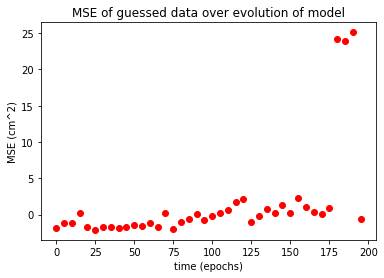

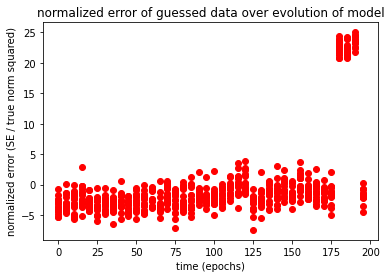

In [196]:
net.apply(weights_init)
dlg_MSE, dlg_n_errors = train_net_Adam_DLG(train_data, train_target, batch_size = 16, epochs = 200, verbose = False, dlg_rate = 5)
test_net(test_data, test_target, verbose = False)

# create pyplot of SE over time
plt.plot(dlg_MSE[0], torch.log(torch.tensor(dlg_MSE[1])), 'ro')
plt.title('MSE of guessed data over evolution of model')
plt.xlabel('time (epochs)')
plt.ylabel('MSE (cm^2)')
plt.show()

plt.plot(dlg_n_errors[0], torch.log(torch.tensor(dlg_n_errors[1])), 'ro')
plt.title('normalized error of guessed data over evolution of model')
plt.xlabel('time (epochs)')
plt.ylabel('normalized error (SE / true norm squared)')
plt.show()

# Results

# For Reference (to remove)

In [78]:
# testing Batch-DLG on n random flowers
def test_rand(n = 10, verbose = False):
    length = dst.data.shape[0]
    perm = list(range(length))
    shuffle(perm)
    flower_indices = perm[0:n]
    if (verbose):
        print('flowers: ', flower_indices)

    original_dy_dx, gt_dataset, gt_labels = batch_grad(flower_indices, 0)
    guess, steps = batch_DLG(original_dy_dx, n, 4, 3, 1)
    if (verbose):
        print(f"Original data: {gt_dataset}")
        print(f"Predicted data: {guess}")
        print('steps: ', steps)

    guess_perm = assign_guess(guess, gt_dataset, n, verbose)

    if (verbose):
        print('side by side comparison of guessed to actual input data: ')
    avg_cos_angle = 0
    cos_angles = []
    SEs = []
    n_errors = []
    best_MSE = 0
    for i in range(n):
        SE = torch.sum((guess_perm[i]-gt_dataset[i])**2).item()
        cos_angle = (torch.sum(guess_perm[i]*gt_dataset[i]).item() / (torch.linalg.norm(gt_dataset[i]) * torch.linalg.norm(guess_perm[i]))).item()
        cos_angles.append(cos_angle); avg_cos_angle += cos_angle
        best_MSE += SE; SEs.append(SE)
        n_error = (torch.sum((guess_perm[i]-gt_dataset[i])**2) / (torch.linalg.norm(gt_dataset[i])**2)).item(); n_errors.append(n_error)

        if (verbose):
            print(i, ':', gt_dataset[i].tolist(), guess_perm[i].tolist())
            print('SE: ', SE, 'cos(angle): ', cos_angle)

    avg_cos_angle /= n
    best_MSE /= n
    if (verbose):
        print('average cos(angle): ', avg_cos_angle)
        print('MSE: ', best_MSE)
        print(cos_angles)
        print(SEs)
        print(n_errors)
    
    return SEs, cos_angles, n_errors, steps

In [101]:
# testing batch-DLG on 20 groups of 10 flowers
test_len = 10
errors = []
cos_angles = []
n_errors = []
optimization_steps = []
for i in range(test_len):
    terrors, tcos_angles, tn_errors, steps = test_rand(10, False)
    #print(terrors, tcos_angles)
    errors += terrors
    optimization_steps.append(steps)
    cos_angles += tcos_angles
    n_errors += tn_errors
    
print(errors)
print(optimization_steps)
print(cos_angles)
print(n_errors)

[2.3446601089363006, 34.472219034986566, 3.912807952167283, 0.14527173830747464, 5.638312943516269, 1.6868576673759306, 28.88330048826552, 0.344529653613356, 0.8080869160971998, 0.5738126446620353, 0.8731898826960088, 1.8692316104848434, 0.3969384911227785, 13.985384978614873, 13.258800760673559, 1.2862895382763107, 2.6918740261069822, 42.77648641639419, 0.5946627384737938, 1.7175004206174591, 0.3824300587653246, 9.16183924574387, 0.26587389744309614, 1.175075701074114, 8.523342039619779, 1.2999915117753529, 0.11491738414905721, 0.19445676196860617, 1.3636930867574848, 1.4020117458943635, 0.08933462051876079, 0.06416510961125832, 0.1547784656126943, 0.08153308774553819, 0.045467496391949115, 0.4503308097027752, 0.08137974202622264, 0.15512380819735225, 0.16462229047361013, 0.09373743032469575, 0.6901337916933918, 5.22846049935971, 0.7902004787512853, 0.532634629806105, 0.1983489931672792, 0.3952148286502919, 13.037033658242292, 0.47171565935053145, 0.6891834710450927, 0.299133270467187

In [102]:
def graph_results(errors, optimization_steps, cos_angles, n_errors):
    # visually represent errors in a histogram
    plt.hist([math.log(elt) for elt in errors], 50)
    plt.title('Distribution of log(SE) of Guessed to Real Input on with 80-100 steps')
    plt.ylabel('Frequency')
    plt.xlabel('Squared Error (cm^2)')
    print('*** change caption This graph was generated on the entire IRIS dataset consisting of 150 flowers.\nIt utilizes a randomly initialized fully connected NN as its prediction algorithm.')
    #plt.savefig('batch-dlg-SE-t.png', dpi=300)
    plt.show()

    # visually represent normalized errors in a histogram (SE / true norm squared)
    plt.hist(n_errors, 50)
    plt.title('Distribution of normalized errors with 80-100 steps')
    plt.ylabel('Frequency')
    plt.xlabel('normalized error (SE / true norm squared)')
    #plt.savefig('batch-dlg-PE-t.png', dpi=300)
    plt.show()

    # visually represent number of optimization steps
    plt.hist(optimization_steps, 10)
    plt.title('Distribution of Optimization Steps of DLG with 80-100 steps')
    plt.xlabel('Number of Optimization Steps')
    plt.ylabel('Frequency')
    #plt.savefig('batch-dlg-steps-t.png', dpi=300)
    print('Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer')
    plt.show()

    # visually represent avg_cos_angles
    plt.hist(cos_angles, 50)
    plt.title('Distribution of cos(angles) of DLG with 80-100 steps')
    plt.xlabel('cos(angle) similarity')
    plt.ylabel('Frequency')
    #plt.savefig('batch-dlg-cangles-t.png', dpi=300)
    plt.show()

*** change caption This graph was generated on the entire IRIS dataset consisting of 150 flowers.
It utilizes a randomly initialized fully connected NN as its prediction algorithm.


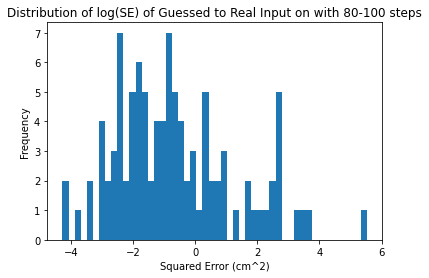

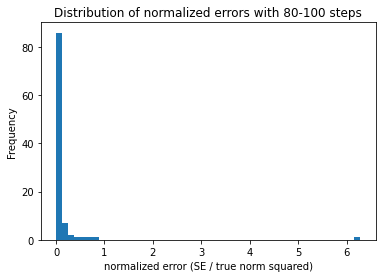

Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer


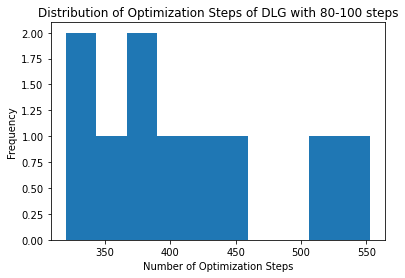

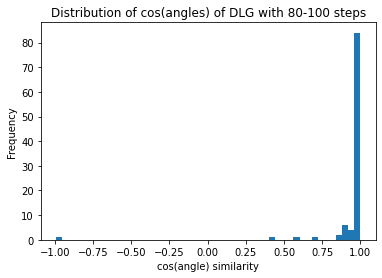

In [103]:
graph_results(errors, optimization_steps, cos_angles, n_errors)

In [12]:
# Todo
# results of train_dlg seem worse
# - check whether having two optimizers at once reduce the effectiveness of each other (shared tensors might lose gradients)
# - see if the model can be trained better
# create the 4 graphs above over time and put results in its own section
# clean up code and comments
# consider factoring out dlg process from the train_adam_dlg